# Coursera-Capstone-Project

**Questions that need to be answered at the end of the project**

1. Locate the areas that have Thai resturants
2. Find places best suited to open thai resturants
3. Which areas have potential for such resturants
4. Visualize the best Thai food locations on the map. 

**Methodology**

1. Collect New York city data from "https://geo.nyu.edu/catalog/nyu_2451_34572"
2. Find venues using Foursquare API.
3. Filter out venues with Thai Restaurents
4. With ratings as a parameter, sort the best restaurents.
5. Visualize the locations on the map

Importing the libraries required for the project

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
#!pip install geocoder
import geocoder
import os
#!pip install folium
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline


print('Libraries imported.')

Libraries imported.


Function to get longitute and longitude of a given location using geopy

In [2]:
 def geo_location(address):
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

Function to extract a fixed number of venues from the Foursquare API within a fixed radius

In [3]:
def get_venues(lat,lng):
    
    radius=1000
    LIMIT=100
    CLIENT_ID = 'JYRXEVCLZ4QDSPA1O5KUFENWSHR3B10B0VNYFV2MAKGHSDKZ'
    CLIENT_SECRET = 'JHOZES4MLPAISJJ3XYE4ZOEDI5BJG3QMPITPATVKLHM0I3CJ'
    VERSION = '20200501' 
    
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    results = requests.get(url).json()
    venue_data = requests.get(url).json()["response"]['groups'][0]['items']
    #venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Function to fetch details of extracted venues

In [4]:

def get_venue_details(venue_id):
        
    CLIENT_ID = 'JYRXEVCLZ4QDSPA1O5KUFENWSHR3B10B0VNYFV2MAKGHSDKZ'
    CLIENT_SECRET = 'JHOZES4MLPAISJJ3XYE4ZOEDI5BJG3QMPITPATVKLHM0I3CJ'
    VERSION = '20200501' 
    
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

Function to get New York City data like Boroughs, Neighbourhoods, longitude and latitude

In [5]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    features=resp['features']
    
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [6]:
new_york_data=get_new_york_data()

In [7]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
new_york_data.shape

(306, 4)

**Create a Bar Plot to visualize different neighborhoods in New York City.**

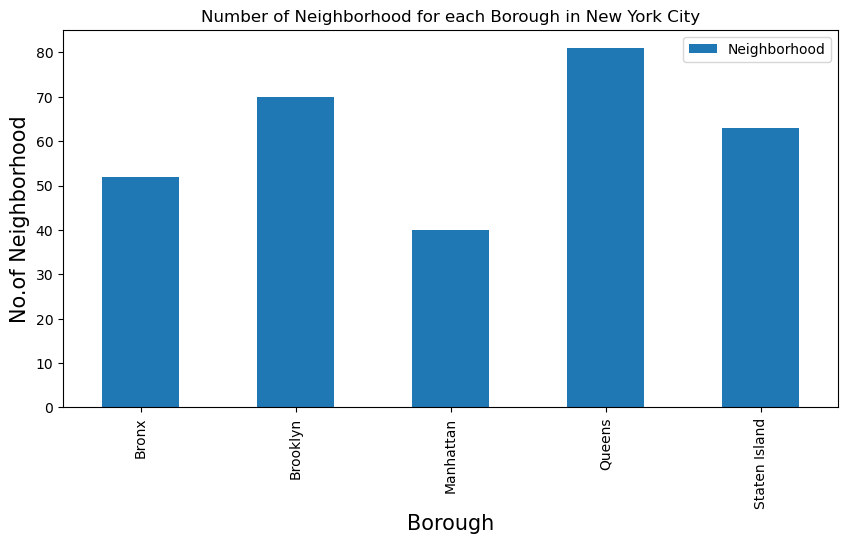

In [9]:
plt.figure(figsize=(10,5), dpi = 100)
plt.title('Number of Neighborhood for each Borough in New York City')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Neighborhood', fontsize=15)
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
plt.legend()
plt.show()

Lets figure out the Thai Restaurants

In [10]:
column_names=['Borough', 'Neighborhood','ID','Name']
thai_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    thai_resturants=venues[venues['Category']=='Thai Restaurant']   
    print('(',count,'/',len(new_york_data),')','Thai Resturants in '+Neighborhood+', '+Borough+':'+str(len(thai_resturants)))
    for resturant_detail in thai_resturants.values.tolist():
        id, name , category=resturant_detail
        thai_rest_ny = thai_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Thai Resturants in Wakefield, Bronx:0
( 2 / 306 ) Thai Resturants in Co-op City, Bronx:0
( 3 / 306 ) Thai Resturants in Eastchester, Bronx:0
( 4 / 306 ) Thai Resturants in Fieldston, Bronx:0
( 5 / 306 ) Thai Resturants in Riverdale, Bronx:1
( 6 / 306 ) Thai Resturants in Kingsbridge, Bronx:1
( 7 / 306 ) Thai Resturants in Marble Hill, Manhattan:1
( 8 / 306 ) Thai Resturants in Woodlawn, Bronx:0
( 9 / 306 ) Thai Resturants in Norwood, Bronx:0
( 10 / 306 ) Thai Resturants in Williamsbridge, Bronx:0
( 11 / 306 ) Thai Resturants in Baychester, Bronx:0
( 12 / 306 ) Thai Resturants in Pelham Parkway, Bronx:0
( 13 / 306 ) Thai Resturants in City Island, Bronx:0
( 14 / 306 ) Thai Resturants in Bedford Park, Bronx:0
( 15 / 306 ) Thai Resturants in University Heights, Bronx:0
( 16 / 306 ) Thai Resturants in Morris Heights, Bronx:0
( 17 / 306 ) Thai Resturants in Fordham, Bronx:0
( 18 / 306 ) Thai Resturants in East Tremont, Bronx:0
( 19 / 306 ) Thai Resturants in West Farms, Bronx:0


( 148 / 306 ) Thai Resturants in Ozone Park, Queens:0
( 149 / 306 ) Thai Resturants in South Ozone Park, Queens:1
( 150 / 306 ) Thai Resturants in College Point, Queens:0
( 151 / 306 ) Thai Resturants in Whitestone, Queens:0
( 152 / 306 ) Thai Resturants in Bayside, Queens:2
( 153 / 306 ) Thai Resturants in Auburndale, Queens:1
( 154 / 306 ) Thai Resturants in Little Neck, Queens:0
( 155 / 306 ) Thai Resturants in Douglaston, Queens:0
( 156 / 306 ) Thai Resturants in Glen Oaks, Queens:1
( 157 / 306 ) Thai Resturants in Bellerose, Queens:0
( 158 / 306 ) Thai Resturants in Kew Gardens Hills, Queens:0
( 159 / 306 ) Thai Resturants in Fresh Meadows, Queens:1
( 160 / 306 ) Thai Resturants in Briarwood, Queens:0
( 161 / 306 ) Thai Resturants in Jamaica Center, Queens:1
( 162 / 306 ) Thai Resturants in Oakland Gardens, Queens:0
( 163 / 306 ) Thai Resturants in Queens Village, Queens:0
( 164 / 306 ) Thai Resturants in Hollis, Queens:0
( 165 / 306 ) Thai Resturants in South Jamaica, Queens:0
( 

( 289 / 306 ) Thai Resturants in Roxbury, Queens:0
( 290 / 306 ) Thai Resturants in Homecrest, Brooklyn:0
( 291 / 306 ) Thai Resturants in Middle Village, Queens:0
( 292 / 306 ) Thai Resturants in Prince's Bay, Staten Island:0
( 293 / 306 ) Thai Resturants in Lighthouse Hill, Staten Island:0
( 294 / 306 ) Thai Resturants in Richmond Valley, Staten Island:1
( 295 / 306 ) Thai Resturants in Malba, Queens:0
( 296 / 306 ) Thai Resturants in Highland Park, Brooklyn:0
( 297 / 306 ) Thai Resturants in Madison, Brooklyn:0
( 298 / 306 ) Thai Resturants in Bronxdale, Bronx:0
( 299 / 306 ) Thai Resturants in Allerton, Bronx:0
( 300 / 306 ) Thai Resturants in Kingsbridge Heights, Bronx:0
( 301 / 306 ) Thai Resturants in Erasmus, Brooklyn:0
( 302 / 306 ) Thai Resturants in Hudson Yards, Manhattan:0
( 303 / 306 ) Thai Resturants in Hammels, Queens:1
( 304 / 306 ) Thai Resturants in Bayswater, Queens:0
( 305 / 306 ) Thai Resturants in Queensbridge, Queens:1
( 306 / 306 ) Thai Resturants in Fox Hills,

In [11]:
thai_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Riverdale,4b94a4a2f964a520787f34e3,Nam Thai
1,Bronx,Kingsbridge,4b94a4a2f964a520787f34e3,Nam Thai
2,Manhattan,Marble Hill,4a739e29f964a520f5dc1fe3,Siam Square
3,Bronx,Country Club,4b4c90d3f964a52046b626e3,Honey's Thai Pavilion
4,Bronx,Parkchester,5585c948498e0bd8a8a706f1,Thai Cuisine


In [12]:
thai_rest_ny.shape

(143, 4)

##### Which borough has most number of  Thai restaurants?

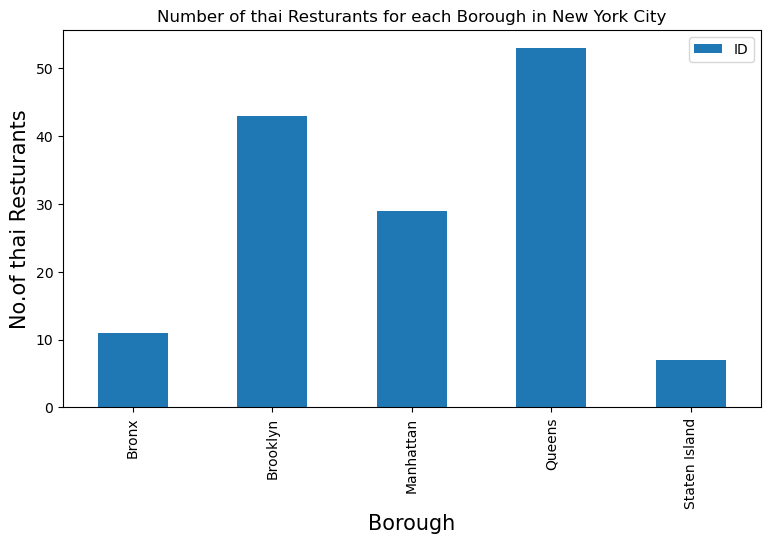

In [13]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of thai Resturants for each Borough in New York City')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of thai Resturants', fontsize=15)
thai_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
plt.legend()
plt.show()

#### We can see that Queens Borough has highest number of Thai resturants whereas staten Island has least number of Thai Resturants


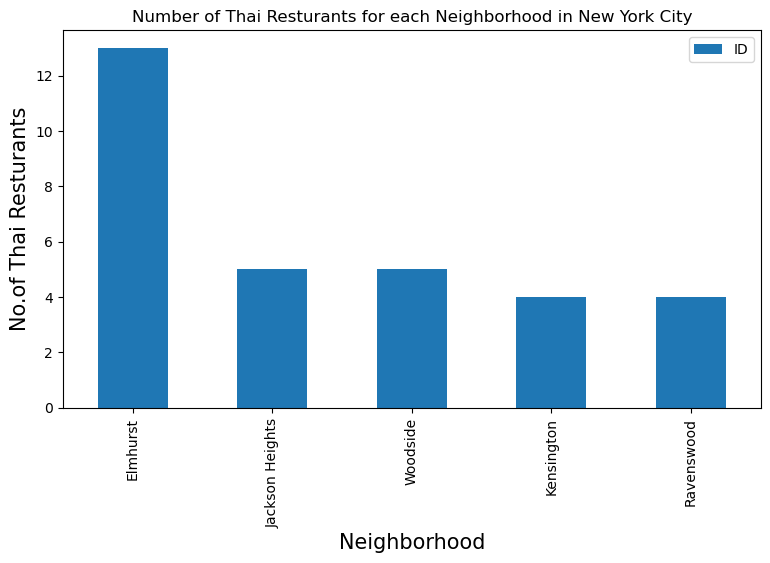

In [14]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Thai Resturants for each Neighborhood in New York City')
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No.of Thai Resturants', fontsize=15)
thai_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
plt.legend()
plt.show()

**From the graph we can see that Elmhurst has the highest number of Thai restaurents, followed by Jackson Heights and Woodside

In [15]:
thai_rest_ny[thai_rest_ny['Neighborhood']=='Elmhurst']

,Borough,Neighborhood,ID,Name
84,Queens,Elmhurst,52f693e6498ed9d2a3fbad75,Eim Khao Mun Kai Elmhurst อิ่ม ข้าวมันไก่เอ็มเ...
85,Queens,Elmhurst,5abad6379de23b5eeb077b04,Lamoon
86,Queens,Elmhurst,56e210f7cd102122a9fb1d1b,Dek Sen
87,Queens,Elmhurst,4b26f895f964a5209d8324e3,Ayada Thai
88,Queens,Elmhurst,593f6541123a19687791b390,Hug Esan NYC
89,Queens,Elmhurst,4ad5173cf964a520c90121e3,Chao Thai ร้านชาวไทย
90,Queens,Elmhurst,53d53756498e2a83f3c2aadb,Paet Rio
91,Queens,Elmhurst,531372e9498ebd3be2888afc,Khao Kang ข้าวแกง
92,Queens,Elmhurst,4c2e801d3ffc952130568ff5,Boon Chu Thai Restaurant
93,Queens,Elmhurst,4ad15d63f964a5203ede20e3,Spicy Shallot


####  Extract Name, ID, Likes, Ratings and Tips from the Foursquare API for further analysis

In [16]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
thai_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in thai_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(thai_rest_ny),')','processed')
    thai_rest_stats_ny = thai_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID      Name  Likes  Rating  Tips
0  4b94a4a2f964a520787f34e3  Nam Thai      3     7.1     5
( 1 / 143 ) processed
                         ID      Name  Likes  Rating  Tips
0  4b94a4a2f964a520787f34e3  Nam Thai      3     7.1     5
( 2 / 143 ) processed
                         ID         Name  Likes  Rating  Tips
0  4a739e29f964a520f5dc1fe3  Siam Square     15     7.3    13
( 3 / 143 ) processed
                         ID                   Name  Likes  Rating  Tips
0  4b4c90d3f964a52046b626e3  Honey's Thai Pavilion     19     7.2    27
( 4 / 143 ) processed
                         ID          Name  Likes  Rating  Tips
0  5585c948498e0bd8a8a706f1  Thai Cuisine     17     7.5     1
( 5 / 143 ) processed
                         ID          Name  Likes  Rating  Tips
0  5585c948498e0bd8a8a706f1  Thai Cuisine     17     7.5     1
( 6 / 143 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 57097b8b498e5431176

                         ID                      Name  Likes  Rating  Tips
0  5303fc3c11d250deaaf46b56  Absolute Thai Restaurant      7     8.0     4
( 57 / 143 ) processed
                         ID                  Name  Likes  Rating  Tips
0  5997796d603d2a7019b8c58e  THEP Thai Restaurant     88     9.0    25
( 58 / 143 ) processed
                         ID                       Name  Likes  Rating  Tips
0  57f81d9e498e82d3766ccce8  PuTawn Local Thai Kitchen     27     8.8     8
( 59 / 143 ) processed
                         ID     Name  Likes  Rating  Tips
0  52be229211d2aabfe6f24d20  Up Thai    637     9.2   163
( 60 / 143 ) processed
                         ID                  Name  Likes  Rating  Tips
0  5997796d603d2a7019b8c58e  THEP Thai Restaurant     88     9.0    25
( 61 / 143 ) processed
                         ID                    Name  Likes  Rating  Tips
0  54600d4a498e6bb7ceb3567d  Senn Thai Comfort Food     60     7.6    24
( 62 / 143 ) processed
              

                         ID      Name  Likes  Rating  Tips
0  595c10c61de76542ca750a50  San Aroy      8     7.6     2
( 110 / 143 ) processed
                         ID                     Name  Likes  Rating  Tips
0  527ef74d11d257effa558059  Thai Kitchen By The Sea     15     6.5    11
( 111 / 143 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4de1791d52b1d38d29571891
( 112 / 143 ) processed
                         ID        Name  Likes  Rating  Tips
0  51cd0030498e1874e3954776  Amina Thai     12     7.0     4
( 113 / 143 ) processed
                         ID             Name  Likes  Rating  Tips
0  53701e2e498e0a21ab0bbb59  Pye Boat Noodle    319     9.1    91
( 114 / 143 ) processed
                         ID      Name  Likes  Rating  Tips
0  51f32456498e149384c052df  Enthaice    141     9.0    49
( 115 / 143 ) processed
                         ID       Name  Likes  Rating  Tips
0  4ab7badef964a5209d7a20e3  Leng Thai  

In [17]:
# Let's list the first five rows of data
thai_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Riverdale,4b94a4a2f964a520787f34e3,Nam Thai,3,7.1,5
1,Bronx,Kingsbridge,4b94a4a2f964a520787f34e3,Nam Thai,3,7.1,5
2,Manhattan,Marble Hill,4a739e29f964a520f5dc1fe3,Siam Square,15,7.3,13
3,Bronx,Country Club,4b4c90d3f964a52046b626e3,Honey's Thai Pavilion,19,7.2,27
4,Bronx,Parkchester,5585c948498e0bd8a8a706f1,Thai Cuisine,17,7.5,1


In [18]:
# Check how many rows and columns in the dataset
thai_rest_stats_ny.shape

(143, 7)

In [19]:
#Convert the tips and likes to datatype float
thai_rest_stats_ny['Likes']=thai_rest_stats_ny['Likes'].astype('float64')
thai_rest_stats_ny['Tips']=thai_rest_stats_ny['Tips'].astype('float64')

#### Find the location with highest likes and ratings

In [20]:
thai_rest_stats_ny.iloc[thai_rest_stats_ny['Likes'].idxmax()]

Borough                           Queens
Neighborhood                    Woodside
ID              3fd66200f964a5204ef11ee3
Name                          SriPraPhai
Likes                                766
Rating                                 9
Tips                                 358
Name: 74, dtype: object

In [21]:
thai_rest_stats_ny.iloc[thai_rest_stats_ny['Tips'].idxmax()]

Borough                           Queens
Neighborhood                    Woodside
ID              3fd66200f964a5204ef11ee3
Name                          SriPraPhai
Likes                                766
Rating                                 9
Tips                                 358
Name: 74, dtype: object

In [22]:
ny_neighborhood_stats=thai_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

Arrange the restaurents in decreasing order of their ratings

In [23]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False)

,Neighborhood,Average Rating
51,Noho,9.400000
10,Chinatown,9.350000
44,Little Italy,9.350000
68,Soho,9.300000
23,Flatiron,9.100000
5,Boerum Hill,9.100000
43,Lenox Hill,9.100000
17,Downtown,9.100000
70,South Ozone Park,9.000000
80,Upper East Side,9.000000


Calculate average rating of each borough

In [24]:
ny_borough_stats=thai_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [25]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.493103
1,Brooklyn,7.934884
3,Queens,7.500000
0,Bronx,5.272727
4,Staten Island,4.228571


We can see from the average rating the Bronx on average doesnt have a good rating which may mean that there is a  lack of good Thai restuarents

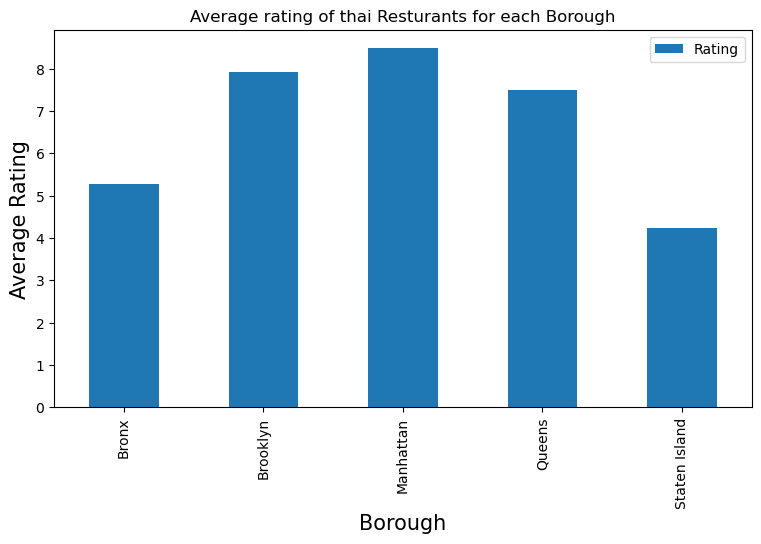

In [26]:

plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of thai Resturants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
thai_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
plt.legend()
plt.show()

In [27]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]


In [28]:
ny_neighborhood_stats

,Neighborhood,Average Rating
1,Astoria,8.650000
5,Boerum Hill,9.100000
8,Bushwick,8.700000
9,Carroll Gardens,8.750000
10,Chinatown,9.350000
11,Clinton,8.100000
12,Clinton Hill,8.233333
13,Cobble Hill,8.200000
15,Crown Heights,8.800000
17,Downtown,9.100000


In [29]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [30]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [31]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Astoria,40.768509,-73.915654,8.650000
1,Brooklyn,Boerum Hill,40.685683,-73.983748,9.100000
2,Brooklyn,Bushwick,40.698116,-73.925258,8.700000
3,Brooklyn,Carroll Gardens,40.680540,-73.994654,8.750000
4,Manhattan,Chinatown,40.715618,-73.994279,9.350000
5,Manhattan,Clinton,40.759101,-73.996119,8.100000
6,Brooklyn,Clinton Hill,40.693229,-73.967843,8.233333
7,Brooklyn,Cobble Hill,40.687920,-73.998561,8.200000
8,Brooklyn,Crown Heights,40.670829,-73.943291,8.800000
9,Brooklyn,Downtown,40.690844,-73.983463,9.100000


Visualize the locations which have a rating above what we specified

In [32]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
incidents = folium.map.FeatureGroup()

for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, 
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
ny_map.add_child(incidents)

# Conclusion

**So now we can answer the questions asked above in the Questions section of the notebook.**

From our anaysis the answers to the above questions are:
1. We found areas which have Thai restuarents. As extracted and analyzed in the notebook. From this we conclude that Queens and Brooklyn are best boroughs as rating and tips are both high in these areas
2. Queen, Brooklyn, and Manhattan are some of the best neighborhoods for Thai cuisine.
3. Bronx has least average rating of any boroughs but that is an oppertunity to open a good quality thai restaurant there and grab the business. 
4. The map shows the best locations for Thai Resturaunts